In [23]:
%matplotlib inline

In [24]:
import mne
import pathlib
import numpy as np
from matplotlib import pyplot as plt, ticker

plt.style.use("minimal.mplstyle")
mne.viz.set_browser_backend("matplotlib")

'matplotlib'

In [25]:
RAW_DATA_PATH = pathlib.Path("../data/EEG")

SESSIONS = [
    "group13_own",
    # "group13b_own"
]

---

In [26]:
epochs = mne.concatenate_epochs(
    [mne.read_epochs(RAW_DATA_PATH.joinpath(SESSION + "-epo.fif")) for SESSION in SESSIONS],
)

Reading /work/DanielAakjærLundgaard#0515/AuthorshipArtifice/analysis/../data/EEG/group13_own-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
10988 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_3038/699126181.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(


Not setting metadata
10988 matching events found
Applying baseline correction (mode: mean)


combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


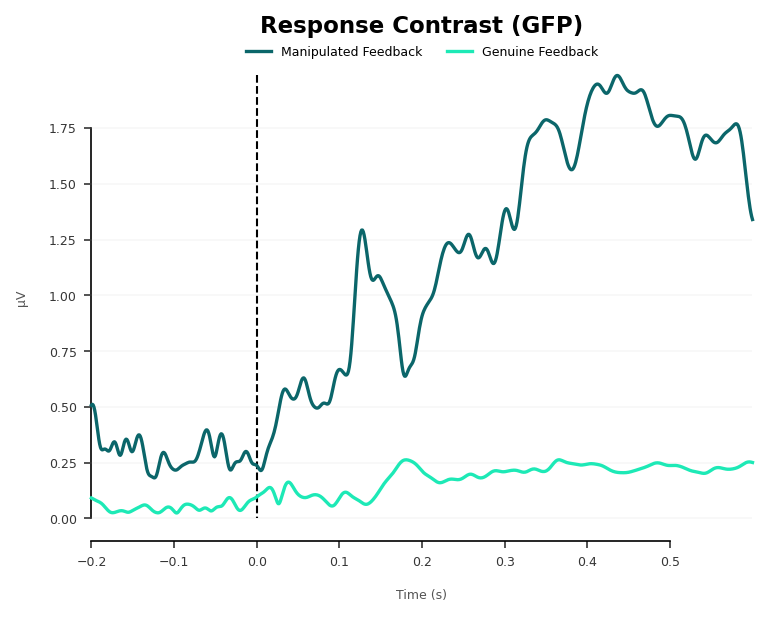

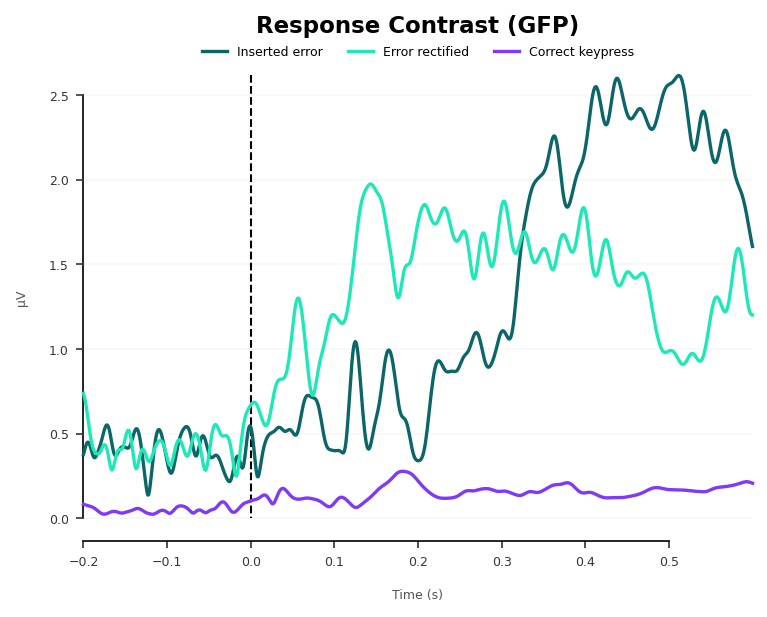

In [27]:
def compare_evoked_activity(conditions):
    fig = mne.viz.plot_compare_evokeds(
        evokeds={condition: epochs[event_keys].average() for condition, event_keys in conditions.items()},
        ci = 0.95,
        combine = "gfp",
        title = "Response Contrast",
        show = False
    )[0]
    fig.set_size_inches((5, 4))
    ax = fig.axes[0]
    ax.autoscale()
    ax.get_legend().remove()
    ax.legend(
        ncol = len(conditions),
        labels = conditions.keys(), 
        bbox_to_anchor = (0.5, 1.04), 
        loc = "upper center"
    )

compare_evoked_activity(conditions = {
    "Manipulated Feedback": ("error inserted", "error rectified"),
    "Genuine Feedback": ("correct", "incorrect"),
})

compare_evoked_activity(conditions = {
    "Inserted error": ["error inserted"],
    "Error rectified": ["error rectified"],
    "Correct keypress": ["correct"],
})

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 30


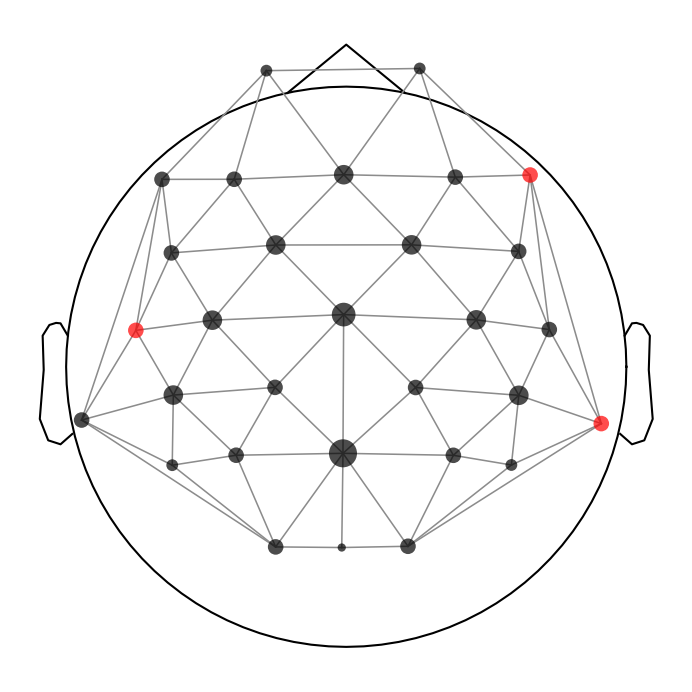

In [28]:
adjacency, ch_names = mne.channels.find_ch_adjacency(epochs.info, ch_type="eeg")
mne.viz.plot_ch_adjacency(epochs.info, adjacency, ch_names);

Using a threshold of 3.843153


/tmp/ipykernel_3038/590797195.py:7: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(


stat_fun(H1): min=0.000000 max=300.010485
Running initial clustering …
Found 18 clusters


  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

Using a threshold of 3.843153


/tmp/ipykernel_3038/590797195.py:7: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(


stat_fun(H1): min=0.000000 max=62.496718
Running initial clustering …
Found 26 clusters


  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

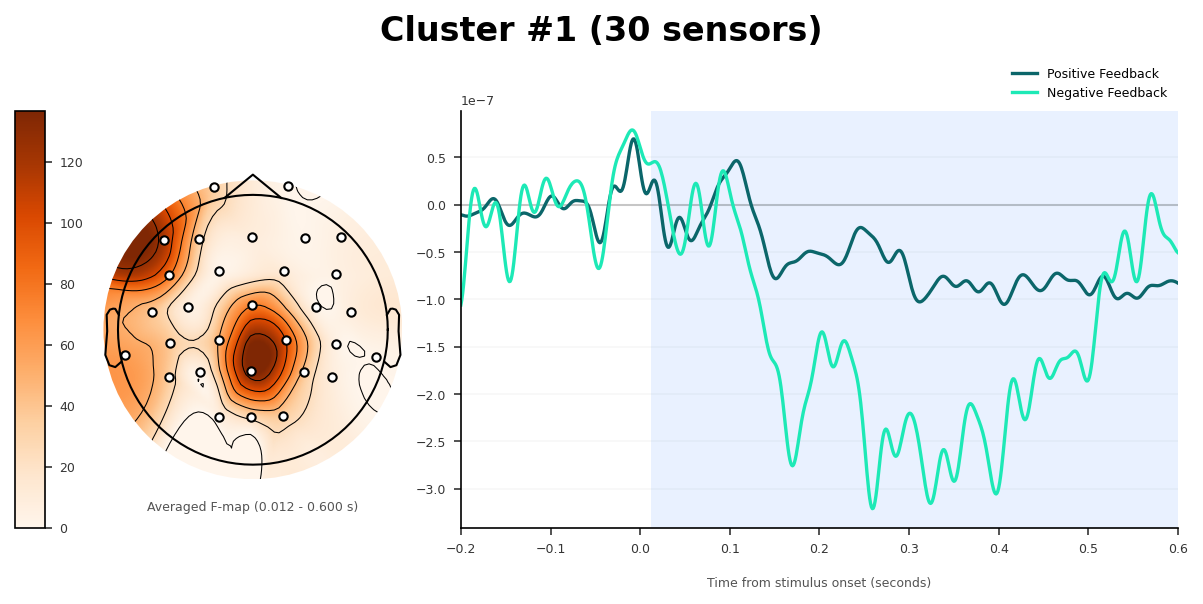

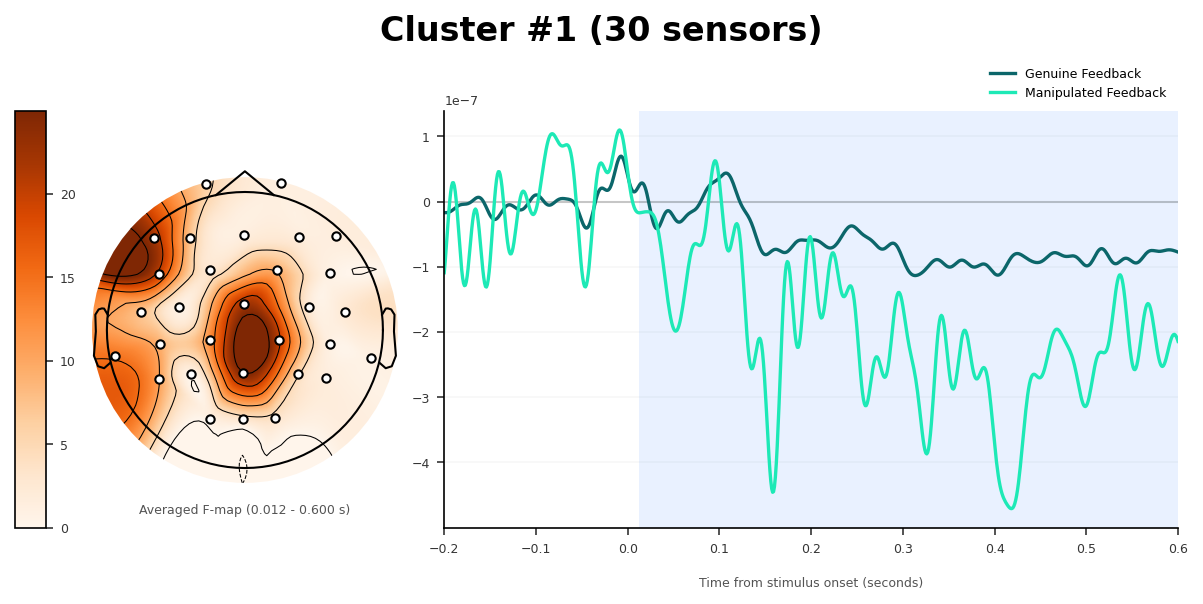

In [46]:
def perform_cluster_permutation(conditions, p_threshold = 0.05):
    def transpose_data(epochs): 
        return np.transpose(epochs.get_data(copy = True), (0, 2, 1))

    transposed_data = [transpose_data(epochs[condition]) for condition in conditions.values()]

    F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(
        X = transposed_data,
        n_permutations=500, 
        tail = 0,
        adjacency=adjacency, 
        seed=69,
        n_jobs=-1, 
    )

    selected_clusters = [cluster for cluster, p_val in zip(clusters, p_values) if p_val < p_threshold]
    if not len(selected_clusters):
        print("No clusters reached set significance threshold of", p_threshold)
    else:
        for cluster_id, cluster in enumerate(selected_clusters):
            time_inds, space_inds = np.squeeze(cluster)
            ch_inds = np.unique(space_inds)
            time_inds = np.unique(time_inds)

            f_map = F_obs[time_inds, ...].mean(axis=0) # topography for stats
            sig_times = epochs.times[time_inds] # signals at the sensors contributing to the cluster

            mask = np.zeros((f_map.shape[0], 1), dtype=bool) # creating spatial mask
            mask[ch_inds, :] = True

            fig, (ax_colorbar, ax_topography, ax_signals) = plt.subplots(
                ncols = 3, 
                figsize=(8, 4), 
                width_ratios = [0.1, 1, 2.4], 
            )
            fig.suptitle(f"Cluster #{cluster_id + 1} ({len(ch_inds)} sensors)")

            image = mne.viz.plot_topomap(
                f_map,
                epochs.info,
                axes=ax_topography,
                cmap="Oranges",
                show=False,
                mask=mask
            )
            fig.colorbar(image[0], fraction = 0.6, cax = ax_colorbar)
            ax_topography.set_xlabel(f"Averaged F-map ({sig_times[0]:0.3f} - {sig_times[-1]:0.3f} s)")

            ax_signals.axhline(
                y = 0, 
                color = "black",
                linewidth = 1,
                alpha = 0.2
            )
            # plot the ERPs in the significant cluster 
            for condition, cluster_signal in zip(conditions.keys(), transposed_data):
                ax_signals.plot(
                    epochs.times, 
                    cluster_signal[:, :, ch_inds].mean(axis=(0, 2)),
                    label=condition
                )
            ax_signals.legend(loc = "lower right", bbox_to_anchor = (1, 1))
            ax_signals.set_xlabel("Time from stimulus onset (seconds)")
            
            ax_signals.axvspan(
                sig_times[0], 
                sig_times[-1], 
                facecolor="C6", 
                alpha=0.1
            )

            plt.tight_layout()

perform_cluster_permutation(
    conditions = {
        "Positive Feedback": ("correct", "error rectified"),
        "Negative Feedback": ("incorrect", "error inserted")
    },
    p_threshold = 0.05
)
perform_cluster_permutation(
    conditions = {
        "Genuine Feedback": ("correct", "incorrect"),
        "Manipulated Feedback": ("error inserted", "error rectified")
    },
    p_threshold = 0.05
)